In [10]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

# Données reconnaissance du locuteur (Chirac/Mitterrand)

In [11]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [12]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

In [13]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])


57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


# Données classification de sentiments (films)

In [14]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [15]:
path = "./datasets/movies/movies1000/"

alltxts_mov,alllabs_mov = load_movies(path)

In [16]:
print(len(alltxts_mov),len(alllabs_mov))
print(alltxts_mov[0])
print(alllabs_mov[0])
print(alltxts_mov[-1])
print(alllabs_mov[-1])

2000 2000
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , 

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [19]:
import string 
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
nltk.download('punkt')

punc = string.punctuation 
punc += '\n\r\t'
stemmer = FrenchStemmer()

print('Original:')
print(f'\nclass: {alllabs[0]} , texte: {alltxts[0]}')
print(f'\nclass: {alllabs[11]} , texte: {alltxts[11]}')
for i in range(0,len(alltxts)):
    #alltxts[i] = re.sub('[0-9]+', '', alltxts[i]) #a garder ou enlever
    alltxts[i] = alltxts[i].lower() 
    alltxts[i] = alltxts[i].translate(str.maketrans(punc, ' ' * len(punc))) #ponctuation
    alltxts[i] = unicodedata.normalize('NFD', alltxts[i]).encode('ascii', 'ignore').decode("utf-8") #normalize en unicode, enleve non ascii et reconvertir en utf 8
    words = word_tokenize(alltxts[i], language='french')
    stemmed = [stemmer.stem(word) for word in words]
    alltxts[i] = ' '.join(stemmed)

print('Processed:')
print(f'\nclass: {alllabs[0]} , texte: {alltxts[0]}')
print(f'\nclass: {alllabs[11]} , texte: {alltxts[11]}')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\titou\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Original:

class: 1 , texte:  quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens   

class: -1 , texte:  Je ne sais ni pourquoi ni comment on s'est opposé il y a quelques douze années - douze ou treize ans - à la création de l'Université technologique.

Processed:

class: 1 , texte: quand je dis cher amis il ne s agit pas la d une formul diplomat mais de l express de ce que je ressen

class: -1 , texte: je ne sais ni pourquoi ni comment on s est oppos il y a quelqu douz anne douz ou treiz an a la creation de l universit technolog


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendre ? Quels sont les avantages et les inconvénients des ces variantes?**

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\titou\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Taille d'origine du vocabulaire: 14374


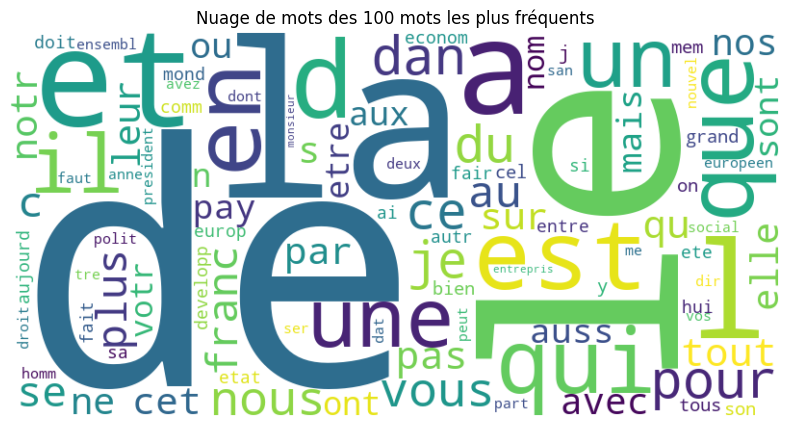

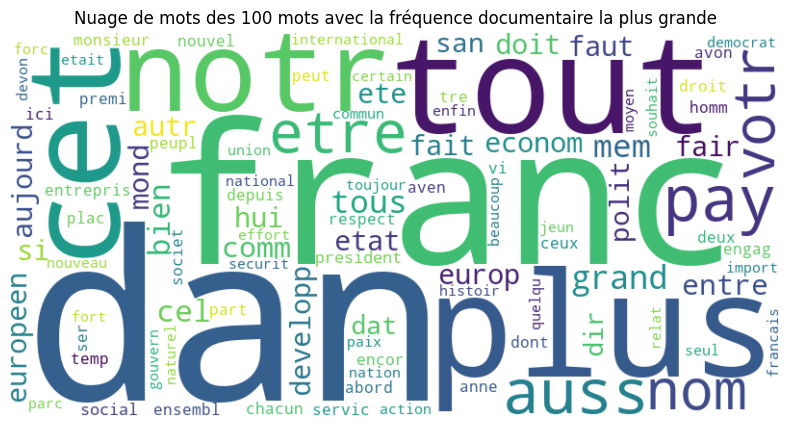

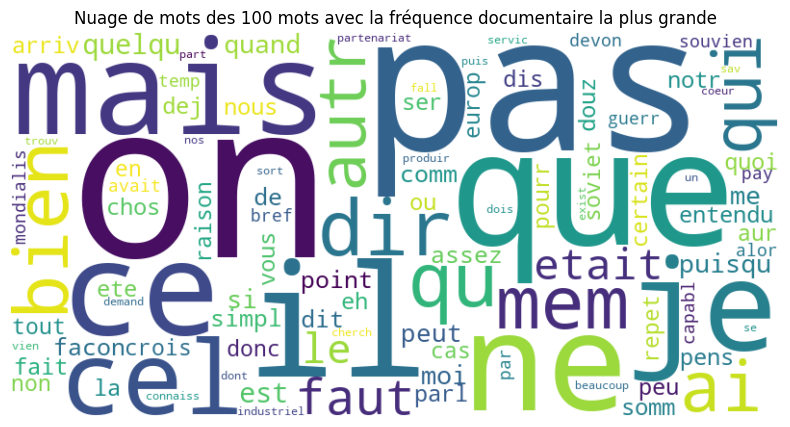

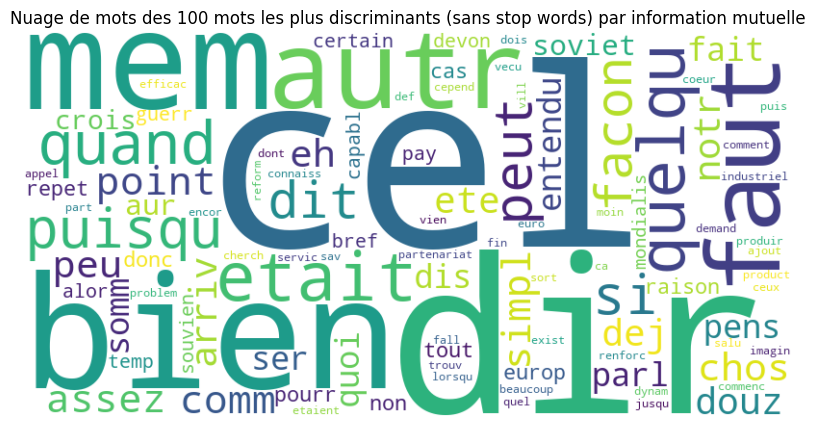

In [43]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

''' Exploration préliminaire des jeux de données '''
nltk.download('stopwords')

all_words = ' '.join(alltxts).split()

# frequence de chaque mot avec counter
word_freq = Counter(all_words)

# Quelle est la taille d'origine du vocabulaire?
original_vocab_size = len(word_freq)
print(f"Taille d'origine du vocabulaire: {original_vocab_size}")

# Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
top_words = word_freq.most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des 100 mots les plus fréquents')
plt.show()

# Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
  max_features=200000,
  min_df=0.2,
  stop_words=final_stopwords_list,
  use_idf=True,
  ngram_range=(1,3))
vectorizer = CountVectorizer(max_features=100, stop_words=final_stopwords_list)
X = vectorizer.fit_transform(alltxts)
feature_names = vectorizer.get_feature_names_out()
wordcloud_doc_freq = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(feature_names, X.sum(axis=0).A1)))
#display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_doc_freq, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des 100 mots avec la fréquence documentaire la plus grande')
plt.show()

#Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
#odds ratio == la probabilité d'occurrence d'un mot dans une classe par rapport à une autre classe
#WITH STOP WORDS
vectorizer_c = CountVectorizer()
X_f = vectorizer_c.fit_transform(alltxts)
mutual_info = mutual_info_classif(X_f, alllabs)
top_indices = sorted(range(len(mutual_info)), key=lambda i: mutual_info[i], reverse=True)[:100]

top_discriminant_words = [(vectorizer_c.get_feature_names_out()[i], mutual_info[i]) for i in top_indices]
wordcloud_discriminant = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_discriminant_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_discriminant, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des 100 mots avec la fréquence documentaire la plus grande')
plt.show()

#WITHOUT STOPWORDS
vectorizer_c = CountVectorizer(stop_words=final_stopwords_list)
X = vectorizer_c.fit_transform(alltxts)
mutual_info = mutual_info_classif(X, alllabs)
top_indices = sorted(range(len(mutual_info)), key=lambda i: mutual_info[i], reverse=True)[:100]
top_discriminant_words = [(vectorizer_c.get_feature_names_out()[i], mutual_info[i]) for i in top_indices]

wordcloud_discriminant = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_discriminant_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_discriminant, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des 100 mots les plus discriminants (sans stop words) par information mutuelle')
plt.show()


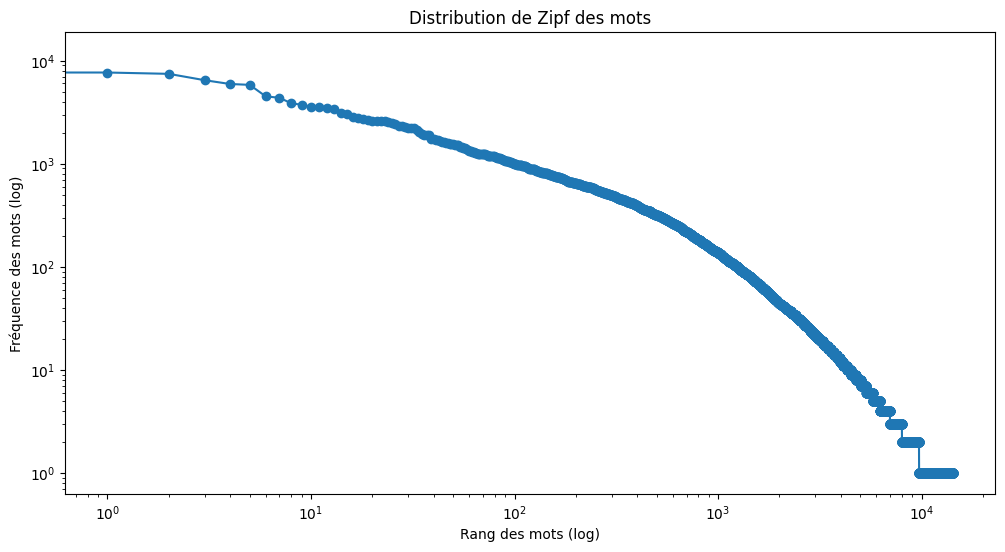

In [44]:
#Quelle est la distribution d'apparition des mots (Zipf)
word_counts = np.array(X.sum(axis=0))[0]
sorted_indices = np.argsort(word_counts)[::-1] 

sorted_word_counts = word_counts[sorted_indices]
plt.figure(figsize=(12, 6))
plt.plot(sorted_word_counts, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution de Zipf des mots')
plt.xlabel('Rang des mots (log)')
plt.ylabel('Fréquence des mots (log)')
plt.show()


In [50]:
#Quels sont les 100 bigrammes/trigrammes les plus fréquents?
vectorizer_ngram = CountVectorizer(ngram_range=(2, 3), stop_words=final_stopwords_list) #both bigramme et trigramme
X = vectorizer_ngram.fit_transform(alltxts)

ngram_frequencies = zip(vectorizer_ngram.get_feature_names_out(), X.sum(axis=0).A1)
sorted_ngrams = sorted(ngram_frequencies, key=lambda x: x[1], reverse=True) #on reverse pour avoir les valeurs plus elevees en premier
top_ngrams = sorted_ngrams[:100]
print(top_ngrams)

if False: #si on veut aussi voir les trigrammes pcq ils ne sont quasiment pas dans le top 100
    vectorizer_ngram = CountVectorizer(ngram_range=(3, 3), stop_words=final_stopwords_list)
    X = vectorizer_ngram.fit_transform(alltxts)

    ngram_frequencies = zip(vectorizer_ngram.get_feature_names_out(), X.sum(axis=0).A1)
    sorted_ngrams = sorted(ngram_frequencies, key=lambda x: x[1], reverse=True) #on reverse pour avoir les valeurs plus elevees en premier
    top_ngrams = sorted_ngrams[:100]
    print(top_ngrams)


[('aujourd hui', 2581), ('monsieur president', 923), ('doit etre', 818), ('notr pay', 792), ('union europeen', 664), ('dan cet', 631), ('dan mond', 626), ('mesdam messieur', 611), ('dan domain', 610), ('peut etre', 479), ('votr pay', 461), ('dan notr', 404), ('tout heur', 394), ('plus plus', 386), ('lutt contr', 384), ('plus grand', 371), ('deux pay', 370), ('tout cel', 354), ('dan cadr', 344), ('doivent etre', 305), ('nom nom', 294), ('tous ceux', 283), ('outr mer', 281), ('entre deux', 278), ('servic public', 275), ('tout fait', 271), ('notr societ', 259), ('mem temp', 255), ('premi ministr', 253), ('droit homm', 252), ('econom social', 252), ('mis oeuvr', 252), ('etat unis', 251), ('nation uni', 251), ('monsieur mair', 245), ('chef etat', 235), ('dan pay', 227), ('bien entendu', 224), ('chacun entre', 207), ('dan votr', 205), ('homm femm', 201), ('mis plac', 201), ('san dout', 195), ('plus fort', 194), ('dernier anne', 189), ('tous franc', 185), ('dan tous', 182), ('cet anne', 181),

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

## 3) Post-processing sur les données Président

Pour la tâche de reconnaissance de locuteur, des phrases successives sont souvent associés à un même locuteur. Voir par exemples les 100 premiers labels de la base d'apprentissage. 

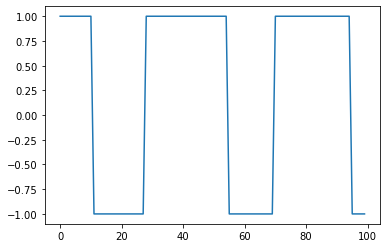

In [ ]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

plt.figure()
plt.plot(list(range(len(alllabs[0:100]))),alllabs[0:100])

**Une méthode de post-traitement pour améliorer les résultats consistent à lisser les résultats de la prédictions d'une phrases par les prédictions voisines, en utilisant par exemple une convolution par une filtre Gaussien. Compléter la fonction ci-dessous et tester l'impact de ce lissage sur les performances.**

In [ ]:
def gaussian_smoothing(pred, size):
     # LISSAGE par un filtre Gaussien de taille size - vous pouvez utiliser np.convolve 
    return 0


## 4) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?